Heavy lift from https://botorch.org/tutorials/closed_loop_botorch_only

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from typing import Optional

import torch

from botorch.models.transforms.input import Normalize
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.objective import GenericMCObjective
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from sklearn.manifold import TSNE

from gpytorch.kernels import MaternKernel

import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.acquisition import (
    qLogExpectedImprovement,
    qLogNoisyExpectedImprovement,
    qUpperConfidenceBound
)
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler

import json
import pandas as pd

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

import matplotlib.pyplot as plt

import sys
sys.path.append('/home/ubuntu/Code/silica-np-synthesis/')
from sample_utilities import samples
import numpy as np

In [4]:
## Load existing data

In [5]:
with open('constants_2024_12_16.json', 'rt') as f:
    synth_constants = json.load(f) 

In [6]:
bounds = {}
for reactant, consts in synth_constants.items():
    bound = (consts['minimum_volume_fraction'], consts['maximum_volume_fraction'])
    bounds[reactant] = bound

In [7]:
synth_data = pd.read_csv('synth_table_both_distances_80nmtarget_12_16_24.csv')
synth_data = synth_data[~synth_data['ap_distance'].isna()]
#synth_data = synth_data[synth_data['ap_distance'] < 8]

In [8]:
synth_data

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction,campaign,target_volume,teos_vol_frac,ammonia_vol_frac,water_vol_frac,ethanol_vol_frac,ap_distance,rmse_distance,experiment_status,rank
0,4bec4e18-80bb-44d9-8508-cc464f14b287,50.221052,124.240610,164.940826,1360.597512,0.362682,7.951422,0.009674,2024_10_04_RandomBaseline_v2,1700.0,0.029542,0.073083,0.097024,0.800351,1.293424,0.263329,complete,9.0
1,a180d359-a229-4b3e-a615-2991fd549f42,166.906371,105.547296,82.831240,1344.715094,0.109129,26.426030,0.032207,2024_10_04_RandomBaseline_v2,1700.0,0.098180,0.062087,0.048724,0.791009,1.344181,0.261322,complete,13.0
2,3584700a-8b01-4e59-a53a-1300fd3fac0a,83.477895,57.716266,175.101719,1383.704120,0.218193,13.216927,0.016085,2024_10_04_RandomBaseline_v2,1700.0,0.049105,0.033951,0.103001,0.813944,1.416920,0.258173,complete,17.0
3,0e6edb88-77c3-4984-a38d-198341bba9e1,190.436887,103.859345,139.812858,1265.890910,0.095645,30.151581,0.036353,2024_10_04_RandomBaseline_v2,1700.0,0.112022,0.061094,0.082243,0.744642,1.419393,0.271926,complete,19.0
4,68831f53-4a51-4f12-b385-10c50c8fab46,75.225504,170.914159,187.560764,1266.299573,0.242129,11.910339,0.014352,2024_10_04_RandomBaseline_v2,1700.0,0.044250,0.100538,0.110330,0.744882,1.513687,0.267274,complete,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,8a0bd2de-3c21-4148-b402-efebe0043e63,113.030593,63.731619,237.950905,1285.286883,0.241717,17.895961,0.021502,2024_10_17_RandomBaselineV4,1700.0,0.066489,0.037489,0.139971,0.756051,1.509679,0.259448,complete,38.0
80,e0ec3c4c-a1d6-4cbc-8c5c-3ed0b7a0f7eb,146.446875,158.741058,36.056991,1358.755076,0.186562,23.186710,0.028398,2024_10_17_RandomBaselineV4,1700.0,0.086145,0.093377,0.021210,0.799268,1.460975,0.269177,complete,25.0
81,b59dad1a-4440-453a-b36a-9efd6e49a282,238.200378,76.128058,50.552195,1335.119368,0.114699,37.713902,0.045956,2024_10_17_RandomBaselineV4,1700.0,0.140118,0.044781,0.029737,0.785364,1.543167,0.266579,complete,52.0
82,d0e19177-de83-4147-ad9f-8c5e3a0aeedd,141.247887,170.845489,237.481059,1150.425564,0.193429,22.363562,0.026572,2024_10_17_RandomBaselineV4,1700.0,0.083087,0.100497,0.139695,0.676721,2.356134,1.645520,complete,80.5


In [9]:
x_data = synth_data[['teos_vol_frac', 'ammonia_vol_frac', 'water_vol_frac']]
y_data = - synth_data['rmse_distance']

In [10]:
y_data.min()

-1.6455203909724525

## data pre-processing

In [11]:
y_data_norm = normalize(torch.tensor(y_data.to_numpy()), torch.tensor([[y_data.min()], [y_data.max()]])).reshape(-1,1)

In [12]:
bounds_torch_norm = torch.tensor([bounds['TEOS'], bounds['ammonia'], bounds['water']]).transpose(-1, -2)

In [13]:
bounds_torch_opt = torch.tensor([[0, 0, 0], [1.0, 1.0, 1.0]], dtype = torch.float32)

In [14]:
x_data_torch = torch.tensor(x_data.to_numpy())

In [15]:
x_data_norm = normalize(x_data_torch, bounds_torch_norm)

## Visualize design space

In [16]:
## Concentrations

In [17]:
x_data_norm[:,0]

tensor([0.1396, 0.6299, 0.2793, 0.7287, 0.2446, 0.0132, 0.6882, 0.9679, 0.3468,
        0.5227, 0.9234, 0.8227, 0.2609, 0.8146, 0.3519, 0.7756, 0.8993, 0.3207,
        0.6588, 0.8740, 0.4622, 0.0268, 0.0906, 0.3819, 0.5301, 0.5436, 0.7905,
        0.2192, 0.0098, 0.2776, 0.3102, 0.8948, 0.2654, 0.9302, 0.3518, 0.1946,
        0.2612, 0.8276, 0.5002, 0.8008, 0.0658, 0.0626, 0.2573, 0.3234, 0.0748,
        0.8635, 0.7082, 0.5590, 0.7006, 0.2155, 0.5675, 0.6177, 0.5117, 0.2644,
        0.9307, 0.1939, 0.6996, 0.9120, 0.6091, 0.2899, 0.5825, 0.0233, 0.4721,
        0.6363, 0.4454, 0.6022, 0.7287, 0.1260, 0.5606, 0.3105, 0.8684, 0.7658,
        0.7856, 0.2715, 0.4622, 0.3923, 0.3009, 0.3352, 0.6317, 0.4035, 0.5439,
        0.9294, 0.5220, 0.3284], dtype=torch.float64)

In [18]:
best_10_ind = torch.argsort(y_data_norm, dim = 0, descending = True)[0:10].reshape(-1)

In [19]:
best_10_ind

tensor([16,  6, 30, 36, 83, 17, 35,  2, 43, 25])

In [20]:
X_best10 = x_data_norm[best_10_ind,:]

In [21]:
X_best10.shape

torch.Size([10, 3])

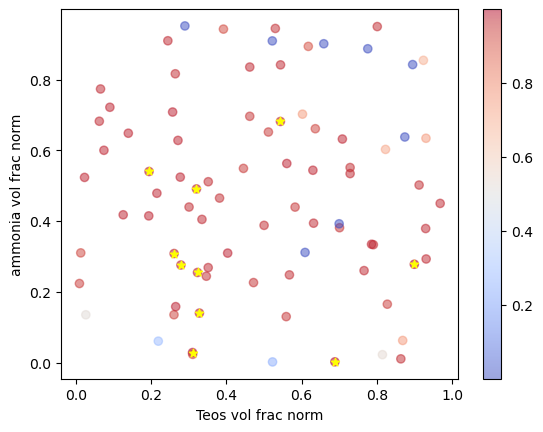

In [22]:
fig, ax = plt.subplots()

sc = ax.scatter(x_data_norm[:,0], x_data_norm[:,1], c = y_data_norm, cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac norm')
ax.set_ylabel('ammonia vol frac norm')


ax.scatter(X_best10[:,0], X_best10[:,1], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

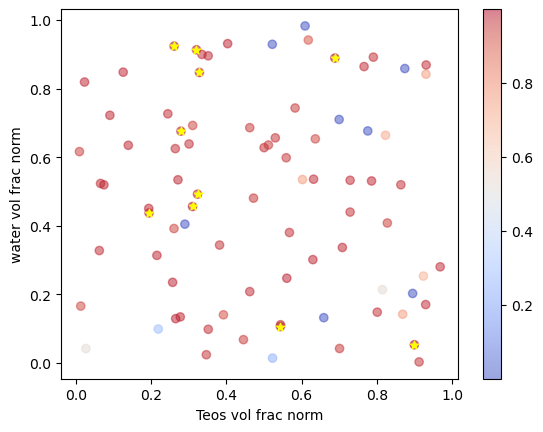

In [23]:
fig, ax = plt.subplots()

sc = ax.scatter(x_data_norm[:,0], x_data_norm[:,2], c = y_data_norm, cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac norm')
ax.set_ylabel('water vol frac norm')


ax.scatter(X_best10[:,0], X_best10[:,2], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

In [24]:
### TSNE rep

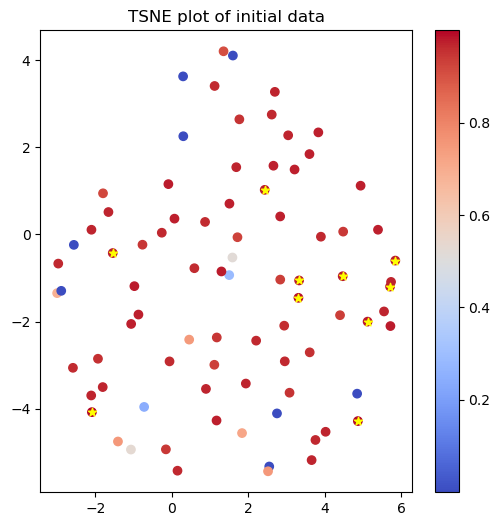

In [25]:

tsne = TSNE()

x_tsne_og = tsne.fit_transform(x_data_norm)

x_tsne_bestn = x_tsne_og[best_10_ind,:]

fig, ax = plt.subplots(figsize = (6,6))

sc = ax.scatter(x_tsne_og[:,0][:len(x_data_norm)], x_tsne_og[:,1][:len(x_data_norm)], c = y_data_norm, cmap = plt.cm.coolwarm)

ax.scatter(x_tsne_bestn[:,0], x_tsne_bestn[:,1], marker = '*', c = 'yellow')
ax.set_title("TSNE plot of initial data")
fig.colorbar(sc, ax = ax)

## Set up BO things

In [26]:
#bounds = torch.tensor([[0.0] * 3, [1.0] * 3], device=device, dtype=dtype)

BATCH_SIZE = 10  if not SMOKE_TEST else 2
NUM_RESTARTS = 50 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 32

N_TRIALS = 3 if not SMOKE_TEST else 2
N_BATCH = 20 if not SMOKE_TEST else 2
MC_SAMPLES = 512 if not SMOKE_TEST else 32

## kernal parameters
nu = 5/2
ard_num_dims = 3 # None to turn off

verbose = False

train_x = x_data_norm
train_y = y_data_norm

In [27]:
def initialize_model(train_x, train_y, state_dict=None, nu = 5/2, ard_num_dims = None):
    # define models for objective and constraint
    kernel = MaternKernel(nu = nu, ard_num_dims = 3)
    model_obj = SingleTaskGP(
        train_x,
        train_y,
        input_transform=Normalize(d=train_x.shape[-1]),
        covar_module=kernel
    ).to(train_x)

    # combine into a multi-output GP model
    mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
    # load state dict if it is passed
    if state_dict is not None:
        model_obj.load_state_dict(state_dict)
    return mll, model_obj

In [28]:
def obj_callable(Z: torch.Tensor, X: Optional[torch.Tensor] = None):
    return Z[..., 0]



objective = GenericMCObjective(objective=obj_callable)

In [29]:
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)




best_observed_all_ei, best_observed_all_nei, best_random_all = [], [], []

# average over multiple trials


best_observed_ei, best_observed_nei, best_random = [], [], []

# call helper functions to generate initial training data and initialize model

mll_nei, model_nei = initialize_model(train_x, train_y)

t0 = time.monotonic()

# fit the models

fit_gpytorch_mll(mll_nei)

# define the qEI and qNEI acquisition modules using a QMC sampler
qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

# for best_f, we use the best observed noisy values as an approximation


qLogNEI = qLogNoisyExpectedImprovement(
    model=model_nei,
    X_baseline=train_x,
    sampler=qmc_sampler,
    objective=objective,
    prune_baseline=True
)

#ucb = qUpperConfidenceBound(
#    model = model_nei, 
##    beta = 5,
#    sampler = qmc_sampler, 
#)

# optimize for new candidates
candidates, _ = optimize_acqf(
    acq_function=qLogNEI,
    bounds=bounds_torch_opt,
    q=BATCH_SIZE,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    #options={"batch_limit": 5, "maxiter": 200},
)




In [30]:
posterior = model_nei.posterior(train_x)
mean = posterior.mean.detach()

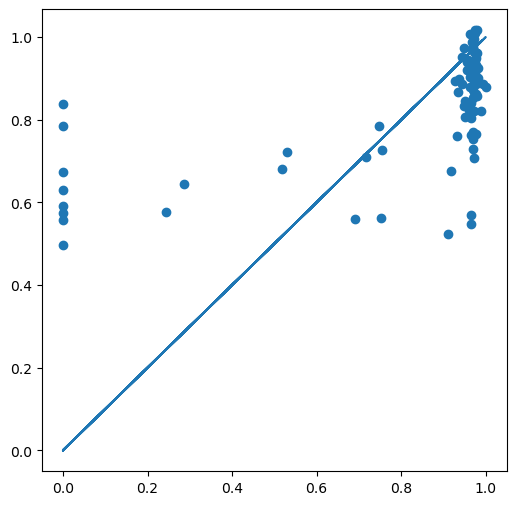

In [31]:
fig, ax = plt.subplots(figsize = (6,6))

ax.scatter(train_y, mean)
ax.plot(train_y, train_y)

(array([ 8.,  0.,  2.,  0.,  0.,  2.,  1.,  4.,  0., 67.]),
 array([4.07048316e-08, 1.00000033e-01, 2.00000025e-01, 3.00000018e-01,
        4.00000010e-01, 5.00000003e-01, 5.99999995e-01, 6.99999987e-01,
        7.99999980e-01, 8.99999972e-01, 9.99999965e-01]),
 <BarContainer object of 10 artists>)

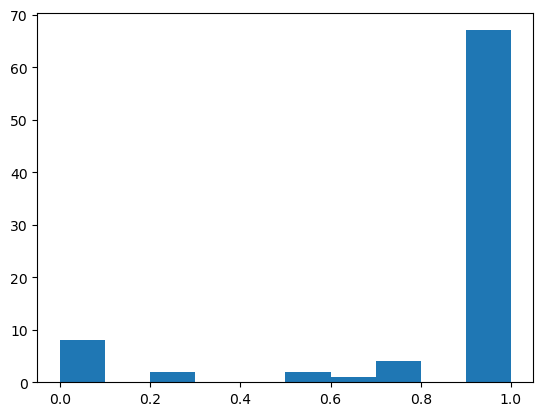

In [32]:
plt.hist(train_y)

In [33]:
train_x.max()

tensor(0.9824, dtype=torch.float64)

## Visualize model predictions

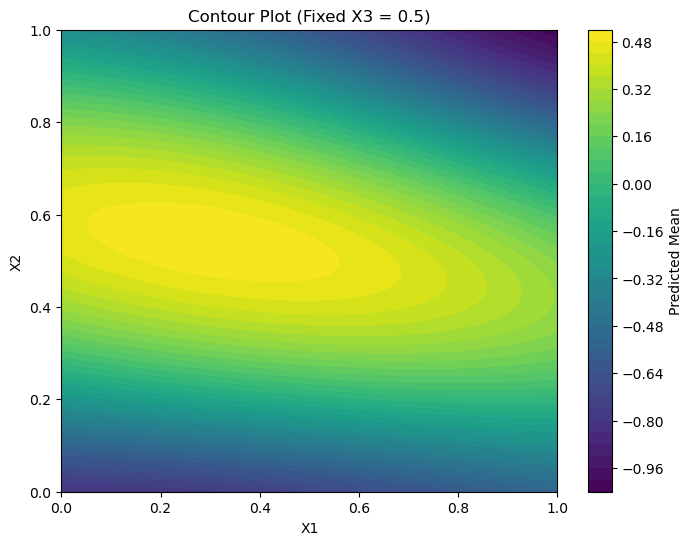

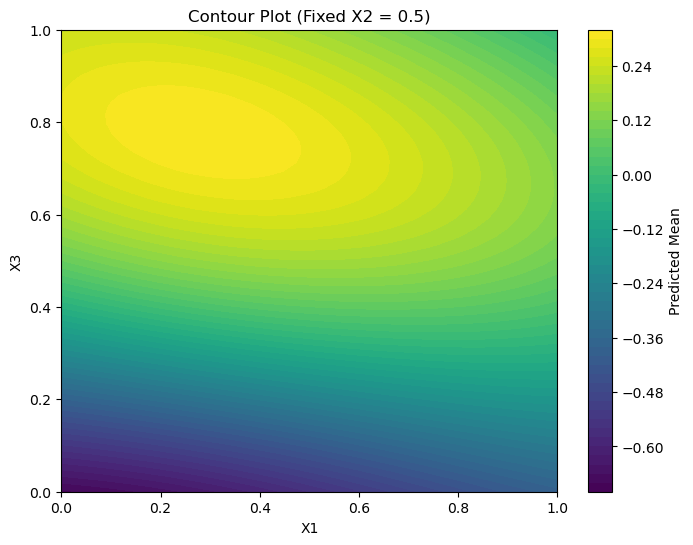

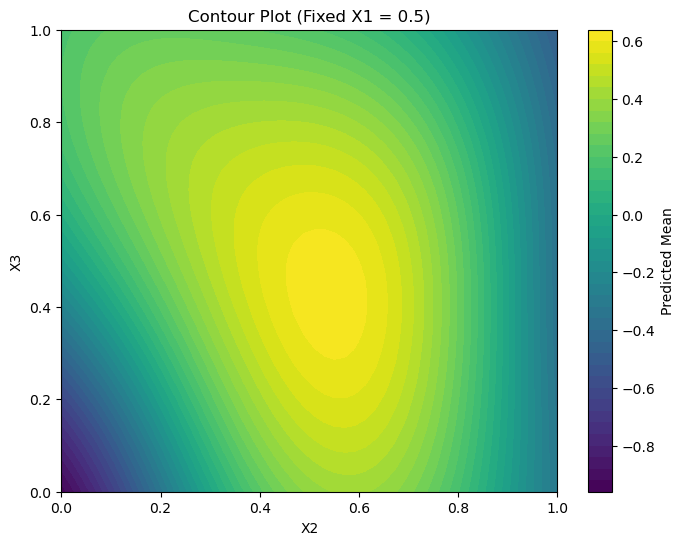

In [34]:
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Helper function to create contour plots
def plot_contour_fixed_dimension(model, fixed_dim, fixed_val, x_range, y_range, dim_labels, title):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict with the model
    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor)
        mean = preds.mean.numpy().reshape(X.shape)  # Reshape to match grid

    # Plot the contour
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, mean, levels=50, cmap="viridis")
    plt.colorbar(cp, label="Predicted Mean")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

# Plot 2D contour slices by fixing each dimension at a particular value
fixed_vals = [0.1, 0.1, 0.1]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=2, fixed_val=fixed_vals[2], 
                             x_range=x, y_range=y, 
                             dim_labels=["X1", "X2"], 
                             title="Contour Plot (Fixed X3 = 0.5)")


# Slice along X1 and X3, fixing X2 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=1, fixed_val=fixed_vals[1], 
                             x_range=x, y_range=z, 
                             dim_labels=["X1", "X3"], 
                             title="Contour Plot (Fixed X2 = 0.5)")

# Slice along X2 and X3, fixing X1 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=0, fixed_val=fixed_vals[0], 
                             x_range=y, y_range=z, 
                             dim_labels=["X2", "X3"], 
                             title="Contour Plot (Fixed X1 = 0.5)")


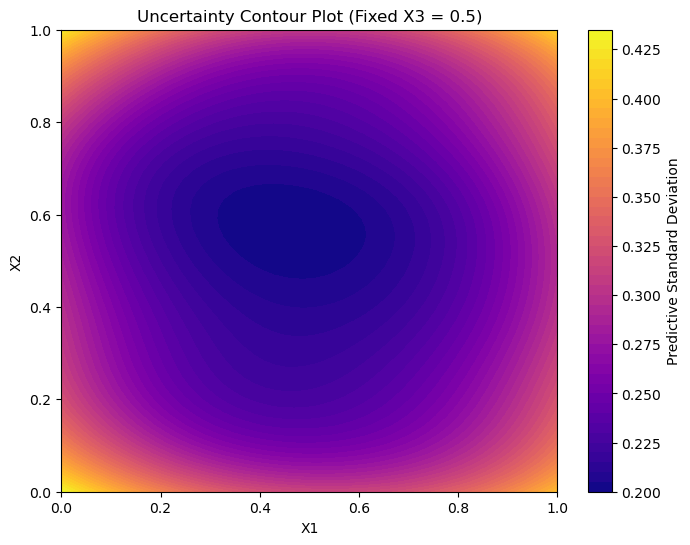

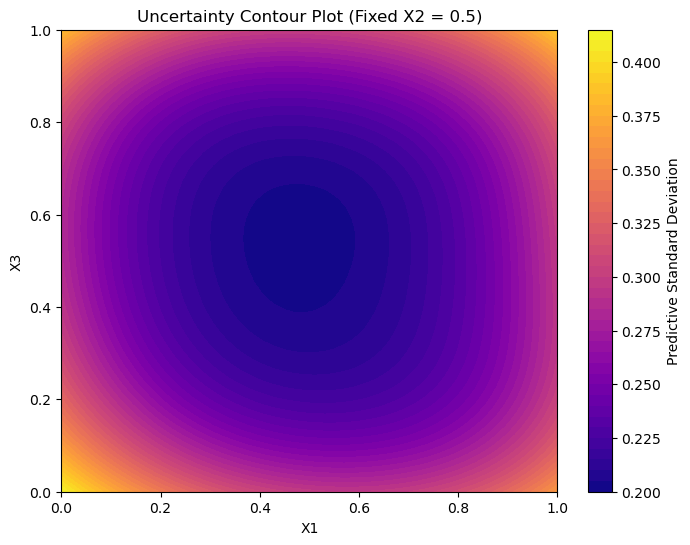

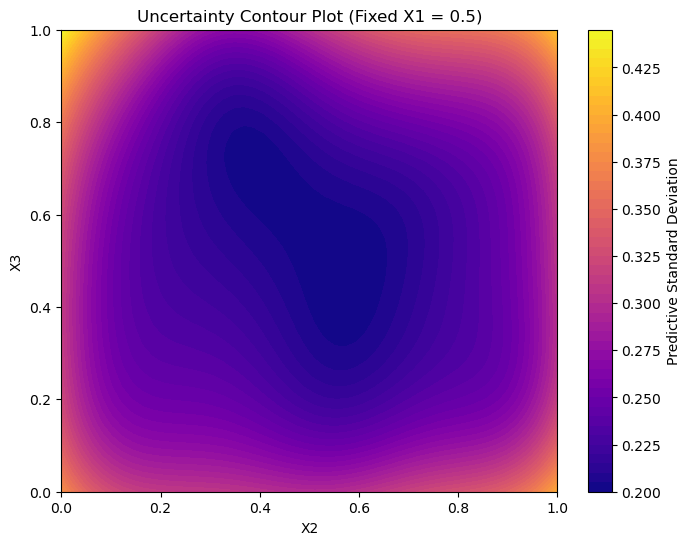

In [35]:
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Helper function to create contour plots for uncertainty
def plot_contour_uncertainty(model, fixed_dim, fixed_val, x_range, y_range, dim_labels, title):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict with the model to get uncertainty (standard deviation)
    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor)
        std_dev = preds.variance.sqrt().numpy().reshape(X.shape)  # Reshape to match grid

    # Plot the contour of uncertainty
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, std_dev, levels=50, cmap="plasma")  # Plasma color map for uncertainty
    plt.colorbar(cp, label="Predictive Standard Deviation")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

# Plot 2D contour slices of uncertainty by fixing each dimension at a particular value
fixed_vals = [0.5, 0.5, 0.5]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_contour_uncertainty(model_nei, fixed_dim=2, fixed_val=fixed_vals[2], 
                         x_range=x, y_range=y, 
                         dim_labels=["X1", "X2"], 
                         title="Uncertainty Contour Plot (Fixed X3 = 0.5)")

# Slice along X1 and X3, fixing X2 at 0.5
plot_contour_uncertainty(model_nei, fixed_dim=1, fixed_val=fixed_vals[1], 
                         x_range=x, y_range=z, 
                         dim_labels=["X1", "X3"], 
                         title="Uncertainty Contour Plot (Fixed X2 = 0.5)")

# Slice along X2 and X3, fixing X1 at 0.5
plot_contour_uncertainty(model_nei, fixed_dim=0, fixed_val=fixed_vals[0], 
                         x_range=y, y_range=z, 
                         dim_labels=["X2", "X3"], 
                         title="Uncertainty Contour Plot (Fixed X1 = 0.5)")

## ACQ func value

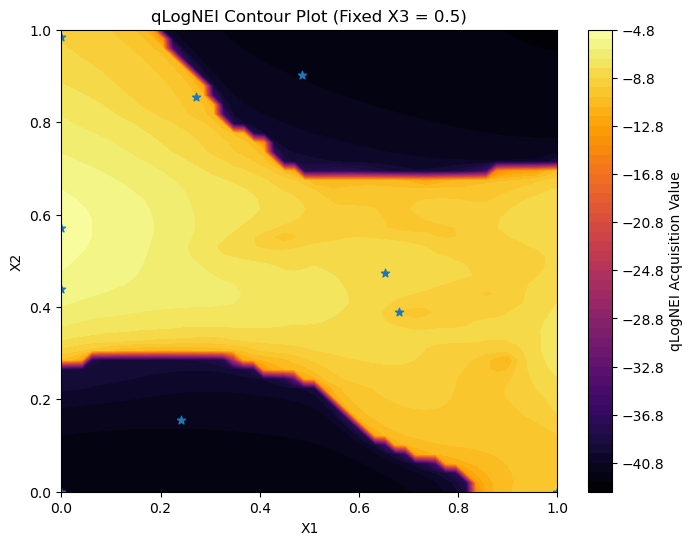

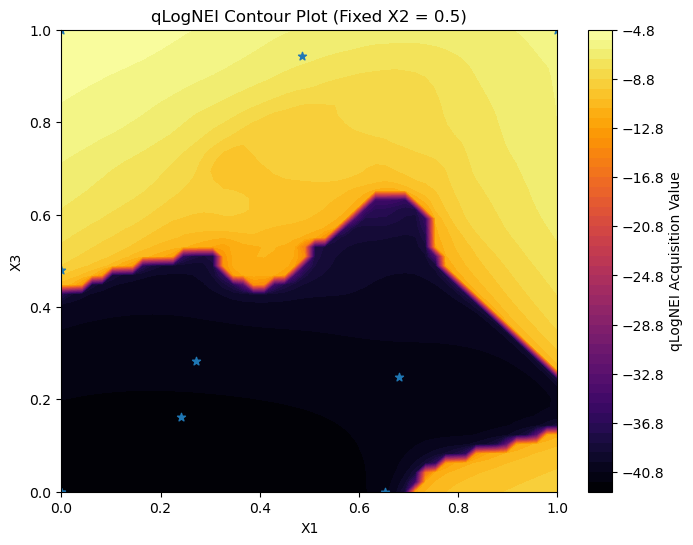

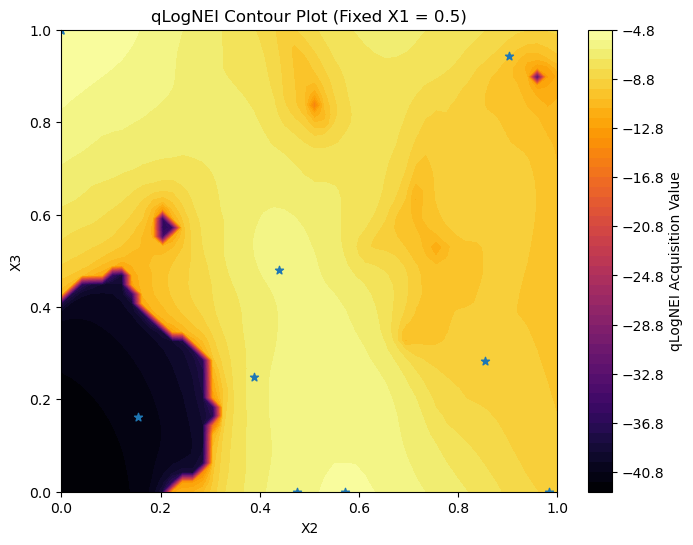

In [36]:
acq_func = qLogNEI
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Helper function to create contour plots for qLogNoisyExpectedImprovement
def plot_qlognei_contour(acq_func, fixed_dim, fixed_val, x_range, y_range, dim_labels, title, candidates = candidates):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Compute qLogNoisyExpectedImprovement values at each grid point individually
    acq_func_values = []
    for i in range(grid_tensor.shape[0]):
        point = grid_tensor[i].unsqueeze(0)  # Make it a batch of 1
        acq_value = acq_func(point).item()  # Evaluate and get scalar value
        acq_func_values.append(acq_value)

    acq_func_values = np.array(acq_func_values).reshape(X.shape)  # Reshape to match grid

    dims = [0,1,2]
    dims.remove(fixed_dim)
    # Plot the contour of qLogNoisyExpectedImprovement
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, acq_func_values, levels=50, cmap="inferno")  # Inferno color map for acquisition function
    plt.scatter(candidates[:,dims[0]], candidates[:,dims[1]], marker = '*')
    plt.colorbar(cp, label="qLogNEI Acquisition Value")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

# Plot 2D contour slices of qLogNEI by fixing each dimension at a particular value
fixed_vals = [0.06, 0.06, 0.06]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=2, fixed_val=fixed_vals[2], 
                     x_range=x, y_range=y, 
                     dim_labels=["X1", "X2"], 
                     title="qLogNEI Contour Plot (Fixed X3 = 0.5)", candidates =  candidates)

# Slice along X1 and X3, fixing X2 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=1, fixed_val=fixed_vals[1], 
                     x_range=x, y_range=z, 
                     dim_labels=["X1", "X3"], 
                     title="qLogNEI Contour Plot (Fixed X2 = 0.5)", candidates = candidates)

# Slice along X2 and X3, fixing X1 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=0, fixed_val=fixed_vals[0], 
                     x_range=y, y_range=z, 
                     dim_labels=["X2", "X3"], 
                     title="qLogNEI Contour Plot (Fixed X1 = 0.5)", candidates = candidates)


## Visualize new batch

In [37]:
tsne = TSNE()

In [38]:
x_data_norm.shape

torch.Size([84, 3])

In [39]:
all_x = torch.cat([x_data_norm, candidates])

In [40]:
x_tsne_og = tsne.fit_transform(all_x)

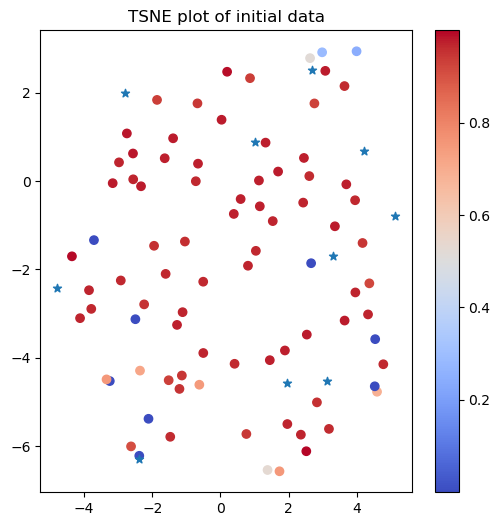

In [41]:
fig, ax = plt.subplots(figsize = (6,6))

sc = ax.scatter(x_tsne_og[:,0][:len(x_data_norm)], x_tsne_og[:,1][:len(x_data_norm)], c = train_y, cmap = plt.cm.coolwarm)
ax.scatter(x_tsne_og[:,0][len(x_data_norm):], x_tsne_og[:,1][len(x_data_norm):], marker='*')
ax.set_title("TSNE plot of initial data")
fig.colorbar(sc, ax = ax)

## Prep new sample table for next experiment

In [42]:
x_fractions = unnormalize(candidates, bounds_torch_norm)

In [43]:
target_volume = 1700
target_dilution = 0.1 # mol Si/L saxs sample
constants_fp = './constants_2024_12_16.json'
samples_write_fp = 'Sample_table_2025_01_09_CompareOpt_80nmTarget_Campaign2_round1_rmsedist.csv'


In [44]:
samples_gen = []
for row in x_fractions:
    teos_vf = float(row[0])
    ammonia_vf = float(row[1])
    water_vf = float(row[2])

    sample = samples.SolidSilicaSample(target_volume, teos_vol_frac = teos_vf, ammonia_vol_frac=ammonia_vf, water_vol_frac=water_vf, reactant_fp = constants_fp)
    sample.calculate_reactant_volumes()
    sample.calculate_dilution_volumefraction(target_dilution)
    sample.calculate_silica_mass_concentration()
    sample.calculate_silica_mass_fraction()
    samples_gen.append(sample)

In [45]:
synth_table = samples.generate_synthesis_table(samples_gen)

In [46]:
synth_table['ethanol_dilute_vol'] = np.round(target_volume*(1-synth_table['dilution_volume_fraction']))
synth_table['sample_dilute_vol'] = np.round(target_volume * synth_table['dilution_volume_fraction'])

In [47]:
synth_table.loc[synth_table['ethanol_dilute_vol'] < 0, 'ethanol_dilute_vol'] = 0
synth_table.loc[synth_table['sample_dilute_vol'] > target_volume, 'sample_dilute_vol'] = target_volume

In [48]:
#assign rows to sample table
rows = ['A', 'B', 'C', 'D', 'E', 'F']
cols = [1, 2, 3, 4, 5, 6, 7, 8]

wells = []

#skip [B,E]x[2,7]
for row in rows:
    for col in cols:
        if row in ['B', 'E'] and col in [2, 7]:
            pass
        else:
            wells.append(row + str(col))

In [50]:
synth_table['well'] = wells[len(synth_table):2*len(synth_table)]


In [51]:
synth_table['dilute_well'] = wells[3*len(synth_table):4*len(synth_table)]

## Visualize new batch

In [52]:
synth_data['rank'] = synth_data['ap_distance'].rank()

In [53]:
best_row = synth_data.iloc[synth_data['ap_distance'].argmin()]

In [54]:
best10 = synth_data.iloc[synth_data['rank'].argsort().iloc[:10]]

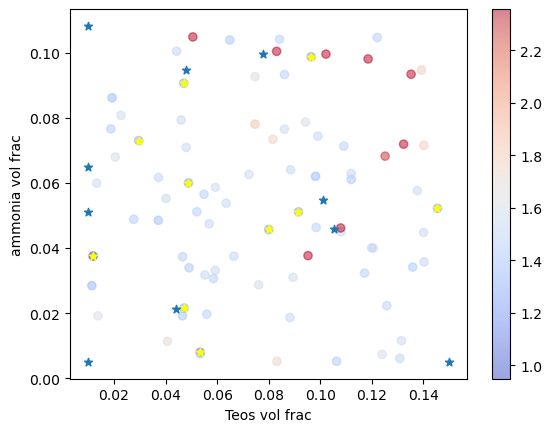

In [55]:
fig, ax = plt.subplots()

sc = ax.scatter(synth_data['teos_vol_frac'], synth_data['ammonia_vol_frac'], c = synth_data['ap_distance'], cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac')
ax.set_ylabel('ammonia vol frac')


ax.scatter(best10['teos_vol_frac'], best10['ammonia_vol_frac'], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

ax.scatter(synth_table['teos_volume']/1700, synth_table['ammonia_volume']/target_volume, marker = '*')

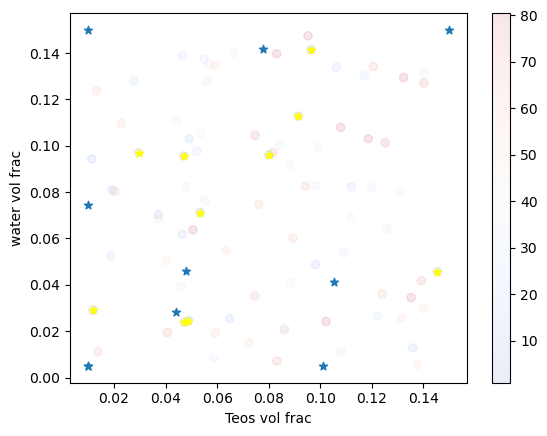

In [56]:
fig, ax = plt.subplots()

sc = ax.scatter(synth_data['teos_vol_frac'], synth_data['water_vol_frac'], c = synth_data['rank'], cmap = plt.cm.coolwarm, alpha=0.1)
ax.set_xlabel('Teos vol frac')
ax.set_ylabel('water vol frac')
cbar = fig.colorbar(sc, ax = ax)

ax.scatter(best10['teos_vol_frac'], best10['water_vol_frac'], marker = '*', color = 'yellow')

ax.scatter(synth_table['teos_volume']/1700, synth_table['water_volume']/target_volume, marker = '*')

In [57]:
synth_table

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction,ethanol_dilute_vol,sample_dilute_vol,dilute_well,well
0,0ffe4963-fabf-4f3a-afa0-2fd3a33c94fe,81.673501,161.088835,78.202185,1379.035479,0.464611,12.931241,0.015841,910.0,790.0,E1,B4
1,a351cf4d-11b9-4220-947c-c6d04c63cff3,17.000000,110.422607,8.500000,1564.077394,2.232143,2.691584,0.003369,0.0,1700.0,E3,B5
2,75bd1ac6-9c78-4a40-bf49-4422566c2c8c,132.579585,169.575426,240.724936,1157.120053,0.286216,20.991123,0.024953,1213.0,487.0,E4,B6
3,32913309-5d80-4fc5-a6f6-58d9c866f81f,17.000000,184.138905,8.500000,1490.361096,2.232143,2.691584,0.003349,0.0,1700.0,E5,B8
4,2c5b15e2-4420-48de-a186-2a0e2b855a12,172.168951,93.161691,8.500000,1426.169358,0.220402,27.259247,0.033612,1325.0,375.0,E6,C1
5,484be621-bbaa-4545-abbd-478caf3069eb,17.000000,8.500000,255.000010,1419.499990,2.232143,2.691584,0.003272,0.0,1700.0,E8,C2
6,d8a7fcc0-4d10-46ec-9d85-14a244d293d1,74.609617,36.110881,48.315820,1540.963682,0.508600,11.812827,0.014694,835.0,865.0,F1,C3
7,c4bf1f70-9c1a-4a11-8cd0-eb926ca32729,17.000000,86.898500,126.634766,1469.466734,2.232143,2.691584,0.003315,0.0,1700.0,F2,C4
8,0f8c3a1b-98e5-472d-87f7-144ef0dc9365,179.092978,77.833098,69.715252,1373.358672,0.211881,28.355517,0.034660,1340.0,360.0,F3,C5
9,8af3b3af-3e4b-4e08-bdf7-522ef354a3ab,255.000010,8.500000,254.938707,1181.561283,0.148810,40.373762,0.047903,1447.0,253.0,F4,C6


In [58]:
synth_table.to_csv(samples_write_fp)